In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

uit_viocd_path = '/content/gdrive/MyDrive/UIT-ViOCD'

In [4]:
import json
import os

# TRAIN
train_file_path = os.path.join(uit_viocd_path, 'train.json')
with open(train_file_path, 'r') as f:
    train_data = json.load(f)
print(f"Number of records: {len(train_data)}")

# DEV
dev_file_path = os.path.join(uit_viocd_path, 'dev.json')
with open(dev_file_path, 'r') as f:
    dev_data = json.load(f)
print(f"Number of records: {len(dev_data)}")

# TEST
test_file_path = os.path.join(uit_viocd_path, 'test.json')
with open(test_file_path, 'r') as f:
    test_data = json.load(f)
print(f"Number of records: {len(test_data)}")

Number of records: 4387
Number of records: 548
Number of records: 549


# 1. EDA

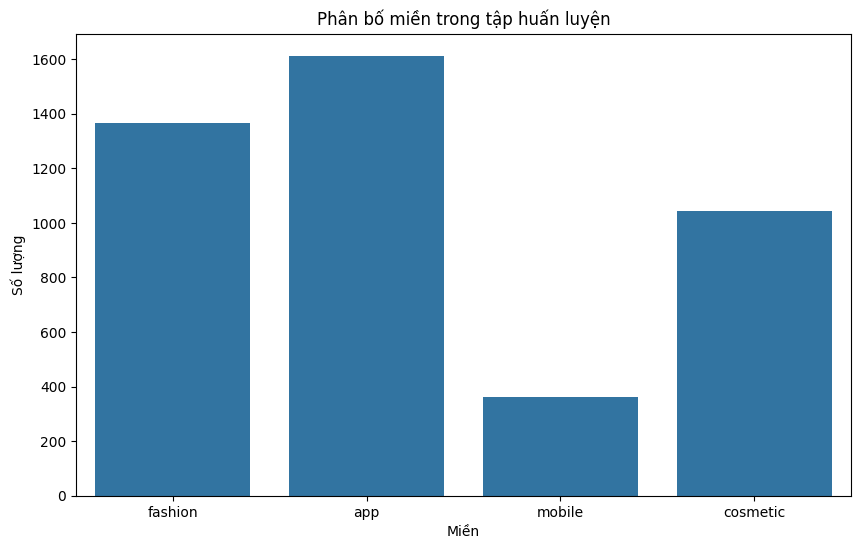

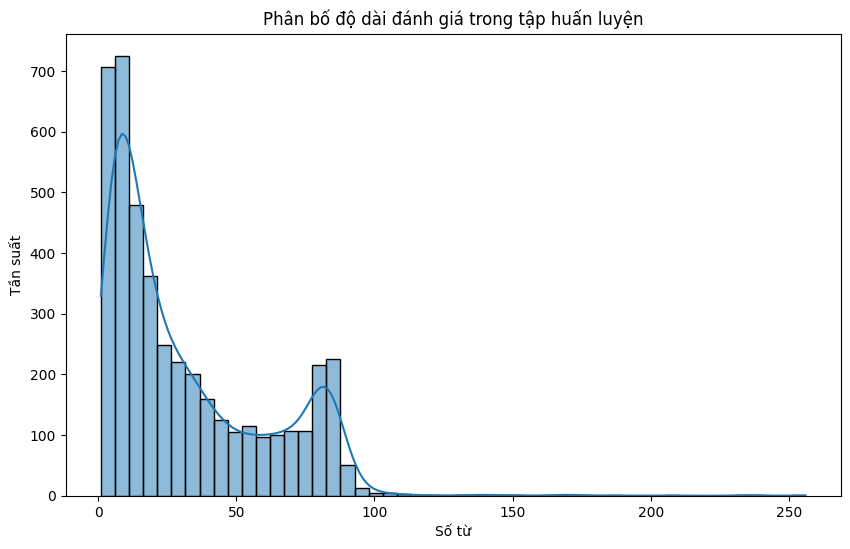

Độ dài trung bình: 31.65
Độ dài tối đa: 256
Độ dài tối thiểu: 1
10 từ phổ biến nhất: [('.', 7089), (',', 4057), ('không', 2780), ('hàng', 2271), ('được', 1823), ('có', 1801), ('rất', 1525), ('thì', 1307), ('mình', 1246), ('tôi', 1163)]


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Trích xuất đánh giá và miền
train_reviews = [item['review'] for item in train_data.values()]
train_domains = [item['domain'] for item in train_data.values()]
dev_reviews = [item['review'] for item in dev_data.values()]
dev_domains = [item['domain'] for item in dev_data.values()]
test_reviews = [item['review'] for item in test_data.values()]
test_domains = [item['domain'] for item in test_data.values()]

# Tạo DataFrames
train_df = pd.DataFrame({'review': train_reviews, 'domain': train_domains})
dev_df = pd.DataFrame({'review': dev_reviews, 'domain': dev_domains})
test_df = pd.DataFrame({'review': test_reviews, 'domain': test_domains})

# Phân bố các miền
domain_names = ['fashion', 'app', 'mobile', 'cosmetic']
plt.figure(figsize=(10, 6))
sns.countplot(x='domain', data=train_df, order=domain_names)
plt.title('Phân bố miền trong tập huấn luyện')
plt.xlabel('Miền')
plt.ylabel('Số lượng')
plt.show()

# Đánh giá độ dài
train_df['length'] = train_df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['length'], bins=50, kde=True)
plt.title('Phân bố độ dài đánh giá trong tập huấn luyện')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.show()

print(f"Độ dài trung bình: {train_df['length'].mean():.2f}")
print(f"Độ dài tối đa: {train_df['length'].max()}")
print(f"Độ dài tối thiểu: {train_df['length'].min()}")

# Các từ phổ biến nhất
all_words = ' '.join(train_reviews).split()
word_freq = Counter(all_words)
print("10 từ phổ biến nhất:", word_freq.most_common(10))

# 2. Huấn luyện mô hình này cho bài toán phân loại domain câu bình luận trên bộ dữ liệu UIT-ViOCD

In [7]:
!pip install transformers
!pip install underthesea

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
import math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ánh xạ tên miền sang nhãn số
domain_to_label = {name: i for i, name in enumerate(domain_names)}

# Chuyển đổi chuỗi miền sang nhãn số
train_labels = [domain_to_label[domain] for domain in train_domains]
dev_labels = [domain_to_label[domain] for domain in dev_domains]
test_labels = [domain_to_label[domain] for domain in test_domains]

# Tokenizer (sử dụng tokenizer của PhoBERT cho tiếng Việt)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Lớp Dataset
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=128):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Tạo các tập dữ liệu
max_len = 128
train_dataset = ReviewDataset(train_reviews, train_labels, tokenizer, max_len)
dev_dataset = ReviewDataset(dev_reviews, dev_labels, tokenizer, max_len)
test_dataset = ReviewDataset(test_reviews, test_labels, tokenizer, max_len)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Triển khai bộ mã hóa Transformer (Transformer Encoder)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = nn.functional.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.dense(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.layer_norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.layer_norm2(x + ff_output)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=3, num_classes=4, max_len=128):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x.transpose(0, 1)).transpose(0, 1)

        # Mask cho padding
        src_key_padding_mask = ~attention_mask.bool()
        src_key_padding_mask = src_key_padding_mask.unsqueeze(1).unsqueeze(2)

        for layer in self.layers:
            x = layer(x, src_key_padding_mask)

        # Gộp trung bình trên chuỗi
        mask = attention_mask.unsqueeze(-1).expand(x.size())
        x = torch.sum(x * mask, dim=1) / torch.sum(mask, dim=1)
        logits = self.classifier(x)
        return logits

# Khởi tạo mô hình
vocab_size = tokenizer.vocab_size
model = TransformerEncoder(vocab_size).to(device)
print(model)

# Hàm huấn luyện
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    return total_loss / len(loader), acc, classification_report(true_labels, preds, target_names=domain_names)

# Huấn luyện mô hình
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 20
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _ = evaluate(model, dev_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Đánh giá trên tập kiểm tra
test_loss, test_acc, report = evaluate(model, test_loader, criterion, device)
print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
print(report)

TransformerEncoder(
  (embedding): Embedding(64000, 256)
  (pos_encoding): PositionalEncoding()
  (layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (wq): Linear(in_features=256, out_features=256, bias=True)
        (wk): Linear(in_features=256, out_features=256, bias=True)
        (wv): Linear(in_features=256, out_features=256, bias=True)
        (dense): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (classifier): Linear(in_features=256, out_features=4, bias=True)
)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Train Loss=0.9223, Val Loss=0.7311, Val Acc=0.7153
Epoch 2: Train Loss=0.6451, Val Loss=0.6710, Val Acc=0.7500
Epoch 3: Train Loss=0.5425, Val Loss=0.5911, Val Acc=0.7883
Epoch 4: Train Loss=0.4574, Val Loss=0.5004, Val Acc=0.8175
Epoch 5: Train Loss=0.3750, Val Loss=0.5518, Val Acc=0.7993
Epoch 6: Train Loss=0.3528, Val Loss=0.5848, Val Acc=0.8212
Epoch 7: Train Loss=0.3050, Val Loss=0.4997, Val Acc=0.8358
Epoch 8: Train Loss=0.2852, Val Loss=0.4703, Val Acc=0.8650
Epoch 9: Train Loss=0.2550, Val Loss=0.5999, Val Acc=0.8230
Epoch 10: Train Loss=0.2404, Val Loss=0.5809, Val Acc=0.8522
Epoch 11: Train Loss=0.2163, Val Loss=0.5706, Val Acc=0.8394
Epoch 12: Train Loss=0.1980, Val Loss=0.5687, Val Acc=0.8394
Epoch 13: Train Loss=0.1856, Val Loss=0.5748, Val Acc=0.8394
Epoch 14: Train Loss=0.1489, Val Loss=0.5536, Val Acc=0.8358
Epoch 15: Train Loss=0.1286, Val Loss=0.6528, Val Acc=0.8358
Epoch 16: Train Loss=0.1217, Val Loss=0.7492, Val Acc=0.8029
Epoch 17: Train Loss=0.1443, Val 